In [494]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx

## Data processing

In [495]:
# net = pn.case9()

# # currently the sn_mva (base power) is inconsistent with that in the original MATPOWER cases
# net.sn_mva = 100

In [496]:
net = pn.case6ww()

# currently the sn_mva (base power) is inconsistent with that in the original MATPOWER cases
net.sn_mva = 100

In [497]:
# # 2-bus simple case

# net = pp.create_empty_network(sn_mva=1)

# # buses
# pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=0)
# pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=1)

# #lines
# pp.create_line_from_parameters(net, 0, 1, length_km=1, r_ohm_per_km=1, x_ohm_per_km=1, c_nf_per_km=0, max_i_ka=0, index=0)

# # generators
# pp.create_ext_grid(net, 0, max_p_mw=1, min_p_mw=0, max_q_mvar=1, min_q_mvar=-1, index=0)
# pp.create_poly_cost(net, 0, "ext_grid", cp1_eur_per_mw=1, cp0_eur=0, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0, index=None)

# # loads
# pp.create_load(net, 1, p_mw=0.01, q_mvar=0, index=0)

In [498]:
# 3-bus no cycle simple case

net = pp.create_empty_network(sn_mva=1)

# buses
pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=0)
pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=1)
pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=2)

#lines
pp.create_line_from_parameters(net, 0, 1, length_km=1, r_ohm_per_km=5, x_ohm_per_km=2, c_nf_per_km=0, max_i_ka=0, index=0)
pp.create_line_from_parameters(net, 2, 0, length_km=1, r_ohm_per_km=1, x_ohm_per_km=1, c_nf_per_km=0, max_i_ka=0, index=1)

# generators
pp.create_ext_grid(net, 0, max_p_mw=1, min_p_mw=0, max_q_mvar=1, min_q_mvar=-1, index=0)
pp.create_poly_cost(net, 0, "ext_grid", cp1_eur_per_mw=1, cp0_eur=0, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0, index=None)

# loads
pp.create_load(net, 1, p_mw=0.01, q_mvar=0, index=0)
pp.create_load(net, 2, p_mw=0.01, q_mvar=0, index=1)

1

In [499]:
# # 3-bus simple case

# net = pp.create_empty_network(sn_mva=1)

# # buses
# pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=0)
# pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=1)
# pp.create_bus(net, vn_kv=1, max_vm_pu=1.1, min_vm_pu=0.9, index=2)

# #lines
# pp.create_line_from_parameters(net, 0, 1, length_km=1, r_ohm_per_km=1, x_ohm_per_km=1, c_nf_per_km=0, max_i_ka=0, index=0)
# pp.create_line_from_parameters(net, 1, 2, length_km=1, r_ohm_per_km=1, x_ohm_per_km=1, c_nf_per_km=0, max_i_ka=0, index=1)
# pp.create_line_from_parameters(net, 2, 0, length_km=1, r_ohm_per_km=1, x_ohm_per_km=1, c_nf_per_km=0, max_i_ka=0, index=2)

# # generators
# pp.create_ext_grid(net, 0, max_p_mw=1, min_p_mw=0, max_q_mvar=1, min_q_mvar=-1, index=0)
# pp.create_poly_cost(net, 0, "ext_grid", cp1_eur_per_mw=1, cp0_eur=0, cq1_eur_per_mvar=0, cq0_eur=0, cp2_eur_per_mw2=0, cq2_eur_per_mvar2=0, index=None)

# # loads
# pp.create_load(net, 1, p_mw=0.01, q_mvar=0, index=0)
# pp.create_load(net, 2, p_mw=0.01, q_mvar=0, index=1)

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


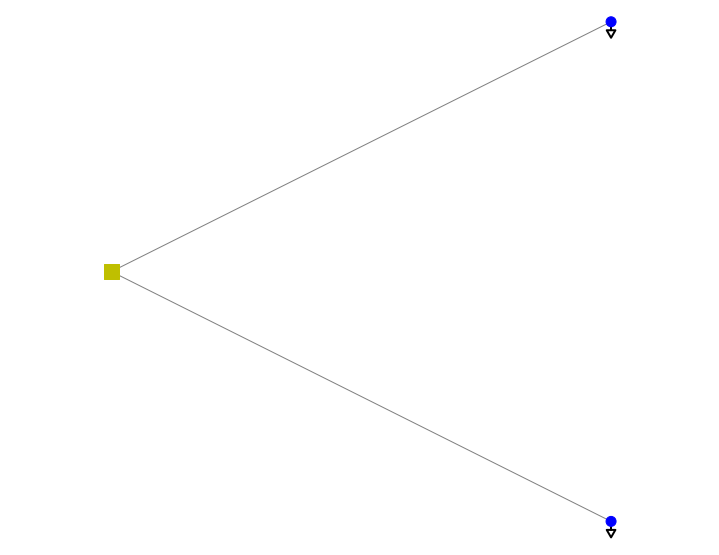

<AxesSubplot:>

In [500]:
simple_plot(net, plot_loads=True, plot_sgens=True)

In [501]:
n = len(net.bus)

#### Generators

In [502]:
gen_df_list = []
gen_name_list = ["gen", "sgen", "ext_grid"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [503]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,1.0,0.0,1.0,-1.0,ext_grid,0.0,1.0,0.0,0.0,0.0,0.0


#### Bus loads

In [504]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [505]:
load_df

,p_mw,q_mvar
0,0.00,0.0
1,0.01,0.0
2,0.01,0.0


#### Admittance matrices

In [506]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

# np.array((net.line['r_ohm_per_km'] * net.line['length_km'] * net.sn_mva * 1e6 / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values * 1e3) ** 2)

In [507]:
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [508]:
G_row_sums = np.sum(G_val, axis=1)
B_row_sums = np.sum(B_val, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        # TODO: figure out how to compute from data
        g = shunt_row["p_mw"].to_numpy()[0]
        b = -shunt_row["q_mvar"].to_numpy()[0]  # FIXME: shunt susceptance is negative as in original data?
    G_val[i][i] = g - G_row_sums[i]
    B_val[i][i] = b - B_row_sums[i]

In [509]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,None,0,1,1.0,5.0,2.0,0.0,0.0,0.0,1.0,1,None,True
1,None,None,2,0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1,None,True


In [510]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

# np.array((net.line['r_ohm_per_km'] * net.line['length_km'] * net.sn_mva * 1e6 / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values * 1e3) ** 2)

In [511]:
graph.edges(data=True)

EdgeDataView([(0, 1, {'key': ('line', 0), 'weight': 1.0, 'path': 1, 'r_pu': 5.0, 'x_pu': 2.0, 'z_pu': 5.385164807134504}), (0, 2, {'key': ('line', 1), 'weight': 1.0, 'path': 1, 'r_pu': 1.0, 'x_pu': 1.0, 'z_pu': 1.4142135623730951})])

In [512]:
G_val

array([[ 0.67241379, -0.17241379, -0.5       ],
       [-0.17241379,  0.17241379,  0.        ],
       [-0.5       ,  0.        ,  0.5       ]])

In [513]:
B_val

array([[-0.56896552,  0.06896552,  0.5       ],
       [ 0.06896552, -0.06896552,  0.        ],
       [ 0.5       ,  0.        , -0.5       ]])

## Variables

In [514]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [515]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [516]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), nonneg=True, value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [517]:
# vectors of cost coefficients: c_[p or q]_[power]

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy(), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy(), nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy(), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy(), nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

## Constraints

In [518]:
constraints = [X >> 0]

In [519]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [520]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [521]:
constraints += [ X[0][0] == 1 ]

In [522]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [523]:
p_cost = cp.sum(c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + c_p_0)
q_cost = cp.sum(c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + c_q_0)

In [524]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [525]:
prob.is_dcp()

True

In [526]:
prob.is_dpp()

True

In [527]:
prob.solve()

# Print result.
print("The optimal value is", prob.value)
# print("A solution X is")
# print(X.value)

The optimal value is 0.020659620917742524


In [528]:
X.value

array([[1.        +0.j        , 0.94676616+0.02j      ,
        0.98979588+0.01j      ],
       [0.94676616-0.02j      , 0.89676616+0.j        ,
        0.93730524-0.01032826j],
       [0.98979588-0.01j      , 0.93730524+0.01032826j,
        0.97979588+0.j        ]])

In [529]:
print(np.linalg.matrix_rank(np.real(X.value)))
print(np.linalg.matrix_rank(np.imag(X.value)))

3
2


In [530]:
np.abs(np.linalg.eigvalsh(X.value))

array([5.62340027e-11, 7.79406392e-11, 2.87656203e+00])

In [531]:
print(p_g.value)
print(q_g.value)

[[0.02065962]]
[[0.00032509]]


In [532]:
prob.status

'optimal'

### Verify case9

In [533]:
X_test = np.array([[1.        +0.j        , 1.05706826-0.08676232j,
        1.0411801 -0.05356282j, 1.0035424 +0.05190931j,
        1.00036631+0.08488358j, 1.04615197-0.0007294j ,
        1.03519631+0.03524898j, 1.04886716-0.00657526j,
        0.98652073+0.09642342j],
       [1.05706826+0.08676232j, 1.124921  +0.j        ,
        1.10524567+0.03371564j, 1.05630904+0.14194135j,
        1.05009077+0.17652184j, 1.10591733+0.08999554j,
        1.09121487+0.12707661j, 1.10929467+0.08405165j,
        1.03445383+0.18751897j],
       [1.0411801 +0.05356282j, 1.10524567-0.03371564j,
        1.08692498+0.j        , 1.04208797+0.1077995j ,
        1.03701489+0.14196154j, 1.08927168+0.05527541j,
        1.07593776+0.09214858j, 1.09241181+0.04933426j,
        1.02198104+0.15323499j],
       [1.0035424 -0.05190931j, 1.05630904-0.14194135j,
        1.04208797-0.1077995j , 1.00979192+0.j        ,
        1.00831625+0.03325595j, 1.04982   -0.05503701j,
        1.04069314-0.01836248j, 1.05224135-0.06104452j,
        0.99502065+0.04555538j],
       [1.00036631-0.08488358j, 1.05009077-0.17652184j,
        1.03701489-0.14196154j, 1.00831625-0.03325595j,
        1.00793797+0.j        , 1.04647327-0.08953079j,
        1.03856757-0.05260927j, 1.04869324-0.09560926j,
        0.99506686+0.01271933j],
       [1.04615197+0.0007294j , 1.10591733-0.08999554j,
        1.08927168-0.05527541j, 1.04982   +0.05503701j,
        1.04647327+0.08953079j, 1.09443448+0.j        ,
        1.08294695+0.03763087j, 1.09727924-0.00611367j,
        1.03198027+0.10159313j],
       [1.03519631-0.03524898j, 1.09121487-0.12707661j,
        1.07593776-0.09214858j, 1.04069314+0.01836248j,
        1.03856757+0.05260927j, 1.08294695-0.03763087j,
        1.07287388+0.j        , 1.08555164-0.04377818j,
        1.02464144+0.06504332j],
       [1.04886716+0.00657526j, 1.10929467-0.08405165j,
        1.09241181-0.04933426j, 1.05224135+0.06104452j,
        1.04869324+0.09560926j, 1.09727924+0.00611367j,
        1.08555164+0.04377818j, 1.10016556+0.j        ,
        1.03409519+0.10762199j],
       [0.98652073-0.09642342j, 1.03445383-0.18751897j,
        1.02198104-0.15323499j, 0.99502065-0.04555538j,
        0.99506686-0.01271933j, 1.03198027-0.10159313j,
        1.02464144-0.06504332j, 1.03409519-0.10762199j,
        0.98252062+0.j        ]])

In [534]:
pq_g_test = np.array([[134.48264792,  25.00212836],
       [ 94.32664507,  -4.00461669],
       [ 90.12033073,  -6.1499994 ]]) / net.sn_mva

In [535]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("active %d"  %(i))
    print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
    print("reactive %d"  %(i))
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

active 0
[134.48264792]
(-0.06319442344827586+0j)
reactive 0
[25.00212836]
(0.017214638620689615+0j)
active 1
[-0.01]
(0.01768235655172412+0j)
reactive 1
[0.]
(-0.010279521379310347+0j)
active 2
[-0.01]
(0.04965385+0j)
reactive 2
[0.]
(-0.003908970000000012+0j)


In [536]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print((np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))/(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]))

[0.99931147+0.j]
[inf+nanj]
[inf+nanj]


/tmp/ipykernel_3973/2328657000.py:3: RuntimeWarning: divide by zero encountered in true_divide
  print((np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))/(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]))
/tmp/ipykernel_3973/2328657000.py:3: RuntimeWarning: invalid value encountered in true_divide
  print((np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))/(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]))


### Verify case6ww

In [537]:
X_test = np.array([[1.1025    +0.j        , 1.10217827+0.02663309j,
        1.123092  +0.03027538j, 1.03598829+0.04829751j,
        1.03224624+0.06220358j, 1.05293071+0.06416317j],
       [1.10217827-0.02663309j, 1.1025    +0.j        ,
        1.12349562+0.00313601j, 1.03685269+0.02325704j,
        1.03344766+0.03724945j, 1.05417343+0.0387088j ],
       [1.123092  -0.03027538j, 1.12349562-0.00313601j,
        1.1449    +0.j        , 1.0566643 +0.02075067j,
        1.05323423+0.03501923j, 1.07435885+0.03644741j],
       [1.03598829-0.04829751j, 1.03685269-0.02325704j,
        1.0566643 -0.02075067j, 0.97560489+0.j        ,
        0.97269778+0.01323107j, 0.99222024+0.01416632j],
       [1.03224624-0.06220358j, 1.03344766-0.03724945j,
        1.05323423-0.03501923j, 0.97269778-0.01323107j,
        0.96997877+0.j        , 0.98945574+0.00066769j],
       [1.05293071-0.06416317j, 1.05417343-0.0387088j ,
        1.07435885-0.03644741j, 0.99222024-0.01416632j,
        0.98945574-0.00066769j, 1.00932426+0.j        ]])

In [538]:
pq_g_test = np.array([[76.72328296, 61.25990873],
                     [73.56969147, 85.79073847],
                     [66.45887933, 29.40322149]]) / net.sn_mva

In [539]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("Active constraint %d" %(i))
    print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
    print("Reactive constraint %d" %(i))
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

Active constraint 0
[76.72328296]
(0.00673392551724139+0j)
Reactive constraint 0
[61.25990873]
(-0.03000341379310345+0j)
Active constraint 1
[-0.01]
(-0.0017812941379310443+0j)
Reactive constraint 1
[0.]
(0.004614100344827593+0j)
Active constraint 2
[-0.01]
(-0.004233689999999957+0j)
Reactive constraint 2
[0.]
(0.026041690000000006+0j)


In [540]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print((np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))/(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]))

[1.00048977+0.j]
[-inf+nanj]
[-inf+nanj]


/tmp/ipykernel_3973/2328657000.py:3: RuntimeWarning: divide by zero encountered in true_divide
  print((np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))/(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]))
/tmp/ipykernel_3973/2328657000.py:3: RuntimeWarning: invalid value encountered in true_divide
  print((np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))/(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]))


### Verify 3-bus simple case

In [541]:
X_test = np.array([[1.        +0.j        , 0.99491792+0.0075j    ,
        0.95782092-0.02j      ],
       [0.99491792-0.0075j    , 0.98991792+0.j        ,
        0.9528032 -0.02708202j],
       [0.95782092+0.02j      , 0.9528032 +0.02708202j,
        0.91782092+0.j        ]])

In [542]:
pq_g_test = np.array([[ 0.02048632, -0.00014214]]) / net.sn_mva

In [543]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

[0.02048632]
(0.012483002068965576+0j)
[-0.00014214]
(0.030146924827586297+0j)
[-0.01]
(-0.0013793103448275779+0j)
[0.]
(0.0009482758620689702+0j)
[-0.01]
(-0.009999999999999953+0j)
[0.]
(-0.02999999999999997+0j)


### Verify 3-bus no-cycle simple case

In [544]:
X_test = np.array([[1.        +0.j        , 0.99491792+0.0075j    ,
        0.98987243-0.005j     ],
       [0.99491792-0.0075j    , 0.98991792+0.j        ,
        0.98480432-0.01239863j],
       [0.98987243+0.005j     , 0.98480432+0.01239863j,
        0.97987243+0.j        ]])

In [545]:
pq_g_test = np.array([[2.01525635e-02, 2.47368045e-05]]) / net.sn_mva

In [546]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("Active constraint %d" %(i))
    print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
    print("Reactive constraint %d" %(i))
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

Active constraint 0
[0.02015256]
(0.003957247068965497+0j)
Reactive constraint 0
[2.47368045e-05]
(0.006621169827586204+0j)
Active constraint 1
[-0.01]
(-0.0013793103448275779+0j)
Reactive constraint 1
[0.]
(0.0009482758620689702+0j)
Active constraint 2
[-0.01]
(-0.0025000000000000022+0j)
Reactive constraint 2
[0.]
(-0.007500000000000007+0j)


### Verify 2-bus simple case

In [547]:
X_test = np.array([[1.        +0.j  , 0.98979587+0.01j],
       [0.98979587-0.01j, 0.97979587+0.j  ]])

In [548]:
pq_g_test = np.array([[0.01010206, 0.00010206]]) / net.sn_mva

In [549]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print(np.sum([pq_g_test[k, 0] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_test[i][i] + np.sum([G_val[i][j] * np.real(X_test[i][j]) + B_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)]))

[0.01010206]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print(np.sum([pq_g_test[k, 1] for k in gen_list]) - q_d_val[i]- (-B_val[i][i] * X_test[i][i] + np.sum([-B_val[i][j] * np.real(X_test[i][j]) + G_val[i][j] * np.imag(X_test[i][j]) for j in graph.neighbors(i)])))